In [90]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from collections import Counter

In [91]:
pol_to_rep = {
  -1.0: 0,
  -0.9: 1,
  -0.8: 2,
  -0.7: 3,
  -0.6: 4,
  -0.5: 5,
  -0.4: 6,
  -0.3: 7,
  -0.2: 8,
  -0.1: 9,
  -0.0: 10,
  0.0: 10,
  0.1: 11,
  0.2: 12,
  0.3: 13,
  0.4: 14,
  0.5: 15,
  0.6: 16,
  0.7: 17,
  0.8: 18,
  0.9: 19,
  1.0: 20,
}

rep_to_pol = {
  0 : -1.0,
  1 : -0.9,
  2 : -0.8,
  3 : -0.7,
  4 : -0.6,
  5 : -0.5,
  6 : -0.4,
  7 : -0.3,
  8 : -0.2,
  9 : -0.1,
  10 : 0.0,
  11 : 0.1,
  12 : 0.2,
  13 : 0.3,
  14 : 0.4,
  15 : 0.5,
  16 : 0.6,
  17 : 0.7,
  18 : 0.8,
  19 : 0.9,
  20 : 1.0,
}

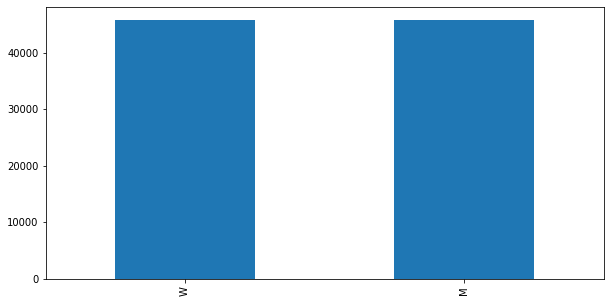

In [92]:
import pandas as pd

df = pd.read_json('../datasets/7_dataset_w_tags_SM.json')

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['Sentiment'] = df.Gender.apply(lambda x: -1 if x == "M" else 1)
df = df.drop('Gender', axis=1)
df['Dep'] = df['Dep'].str.upper()

In [93]:
lemma_vocab = np.unique(df['Lemma']).tolist()
lemma_vocab.insert(0, '<PAD>')

tag_vocab = np.unique(df['Tag']).tolist()
tag_vocab.insert(0, '<PAD>')

pos_vocab = np.unique(df['POS']).tolist()
pos_vocab.insert(0, '<PAD>')

dep_vocab = np.unique(df['Dep']).tolist()
dep_vocab.insert(0, '<PAD>')

df['Polarity_rounded'] = df['Polarity'].apply(lambda s: pol_to_rep[round(float(s), 1)])
polarity_range = []

for i in np.arange(0.0, 2.1, 0.1):
    polarity_range.append(int(round(i*10, 1)))

i_to_lemma = {i:lemma for  i, lemma in enumerate(lemma_vocab)}
lemma_to_i = {lemma:i for  i, lemma in enumerate(lemma_vocab)}

i_to_tag = {i:tag for  i, tag in enumerate(tag_vocab)}
tag_to_i = {tag:i for  i, tag in enumerate(tag_vocab)}

i_to_pos = {i:pos for  i, pos in enumerate(pos_vocab)}
pos_to_i = {pos:i for  i, pos in enumerate(pos_vocab)}

i_to_dep = {i:dep for  i, dep in enumerate(dep_vocab)}
dep_to_i = {dep:i for  i, dep in enumerate(dep_vocab)}

df['Lemma_index'] = df['Lemma'].map(lemma_to_i)
df['Tag_index'] = df['Tag'].map(tag_to_i)
df['POS_index'] = df['POS'].map(pos_to_i)
df['Dep_index'] = df['Dep'].map(dep_to_i)

df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'Sentiment', 'Polarity_rounded', 'Lemma_index', 'Tag_index', 'POS_index', 'Dep_index'].agg(lambda x: list(x))
#df = df.sample(frac=1).reset_index(drop=True)

# df['Word'].apply(lambda s: s.insert(0,"<SOS>"))
# df['Word'].apply(lambda s: s.insert(len(s),"<EOS>"))
# df['Polarity_rounded'].apply(lambda s: s.insert(0,10))
# df['Polarity_rounded'].apply(lambda s: s.insert(len(s),10))


print(polarity_range)

df.head(10)

C:\Users\hanse\AppData\Local\Temp/ipykernel_10288/2858788630.py:36: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'Sentiment', 'Polarity_rounded', 'Lemma_index', 'Tag_index', 'POS_index', 'Dep_index'].agg(lambda x: list(x))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,Sentiment,Polarity_rounded,Lemma_index,Tag_index,POS_index,Dep_index
0,1,"[organizations, decided, drop, women, accused,...","[organization, decide, drop, woman, accuse, in...","[NNS, VBN, VB, NNS, VBD, JJ, NN, JJ, NN]","[NOUN, VERB, VERB, NOUN, VERB, ADJ, NOUN, ADJ,...","[NSUBJ, ROOT, XCOMP, NSUBJ, ADVCL, AMOD, POBJ,...","[-0.19334491413051003, -0.034137248164741, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[8, 10, 9, 14, 10, 10, 9, 11, 10]","[8090, 4708, 5149, 11379, 2872, 6677, 3447, 96...","[21, 34, 31, 21, 32, 12, 18, 12, 18]","[8, 17, 17, 8, 17, 1, 8, 1, 8]","[27, 41, 42, 27, 3, 5, 33, 5, 14]"
1,2,"[Women, previously, worked, winning, actor, to...","[woman, previously, work, win, actor, tell, CN...","[NNS, RB, VBD, VBG, NN, VBD, NNP, RB, NNS, NNS...","[NOUN, ADV, VERB, VERB, NOUN, VERB, PROPN, ADV...","[NSUBJ, ADVMOD, RELCL, AMOD, POBJ, ROOT, DOBJ,...","[0.35316112487835105, -0.039333311401716003, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[14, 10, 6, 7, 10, 9, 10, 10, 10, 12, 11, 10, ...","[11379, 8689, 11391, 11345, 2897, 10514, 516, ...","[21, 24, 32, 33, 18, 32, 19, 24, 21, 21, 18, 2...","[8, 3, 17, 17, 8, 17, 12, 3, 8, 8, 8, 3, 17, 1...","[27, 4, 40, 5, 33, 41, 20, 4, 20, 33, 14, 4, 1..."
2,3,"[response, allegations, Visa, announced, suspe...","[response, allegation, Visa, announce, suspend...","[NN, NNS, NNP, VBD, VBN, NN, NN]","[NOUN, NOUN, PROPN, VERB, VERB, NOUN, NOUN]","[POBJ, POBJ, NSUBJ, ROOT, CCOMP, COMPOUND, POBJ]","[-0.039620517765398, -0.01715489752247, -0.023...","[1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 9, 9, 8, 10]","[9257, 3026, 2671, 3105, 10370, 7447, 3822]","[18, 21, 19, 32, 34, 18, 18]","[8, 8, 12, 17, 17, 8, 8]","[33, 33, 27, 41, 12, 13, 33]"
3,4,"[aware, allegations, Mr.]","[aware, allegation, Mr.]","[JJ, NNS, NNP]","[ADJ, NOUN, PROPN]","[ACOMP, POBJ, COMPOUND]","[-0.035281092794016006, -0.01715489752247, -0....","[1, 1, 1]","[10, 10, 9]","[3325, 3026, 1765]","[12, 21, 19]","[1, 8, 12]","[2, 33, 13]"
4,5,"[point, Visa, suspending, marketing, actor, fe...","[point, Visa, suspend, marketing, actor, featu...","[NN, NNP, VBG, NN, NN, VBN, NNP, VBD, NN]","[NOUN, PROPN, VERB, NOUN, NOUN, VERB, PROPN, V...","[POBJ, NSUBJ, CCOMP, DOBJ, NSUBJPASS, RELCL, N...","[-0.19485058785637502, -0.023234042885702, -0....","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[8, 10, 9, 8, 10, 10, 10, 5, 9]","[8523, 2671, 10370, 7447, 2897, 5697, 2671, 94...","[18, 19, 33, 18, 18, 34, 19, 32, 18]","[8, 12, 17, 8, 8, 17, 12, 17, 8]","[33, 27, 12, 20, 28, 40, 27, 41, 33]"
5,6,"[TransLink, public, transit, system, decided, ...","[TransLink, public, transit, system, decide, s...","[NNP, JJ, NN, NN, VBD, VB, NN, NN, NN, VB, NNP...","[PROPN, ADJ, NOUN, NOUN, VERB, VERB, NOUN, NOU...","[NSUBJ, AMOD, COMPOUND, APPOS, ROOT, XCOMP, DO...","[0.0007588481104900001, -0.139873344780055, -0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10, 9, 10, 8, 10, 10, 10, 10, 10, 10, 10, 5, ...","[2553, 8846, 10733, 10421, 4708, 10156, 11199,...","[19, 12, 18, 18, 32, 31, 18, 18, 18, 31, 19, 1...","[12, 1, 8, 8, 17, 17, 8, 8, 8, 17, 12, 8, 8, 1...","[27, 5, 13, 6, 41, 42, 20, 13, 33, 1, 13, 13, ..."
6,8,"[light, information, learned, allegations, act...","[light, information, learn, allegation, actor,...","[NN, NN, VBN, NNS, NN, NNP, VBN, VB, NN, NNS, ...","[NOUN, NOUN, VERB, NOUN, NOUN, PROPN, VERB, VE...","[POBJ, POBJ, CCOMP, POBJ, COMPOUND, NSUBJ, CCO...","[0.015637420510605002, -0.19751276997209202, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10,...","[7234, 6770, 7156, 3026, 2897, 2553, 4708, 830...","[18, 18, 34, 21, 18, 19, 34, 31, 18, 21, 19, 1...","[8, 8, 17, 8, 8, 12, 17, 17, 8, 8, 12, 8, 8, 8...","[33, 33, 12, 33, 13, 27, 12, 42, 13, 20, 13, 1..."
7,9,"[reaching, Visa, discuss]","[reach, Visa, discuss]","[VBG, NNP, VB]","[VERB, PROPN, VERB]","[ROOT, POBJ, ADVCL]","[-0.09895350657222801, -0.023234042885702, -0....","[1, 1, 1]","[9, 10, 10]

No handles with labels found to put in legend.


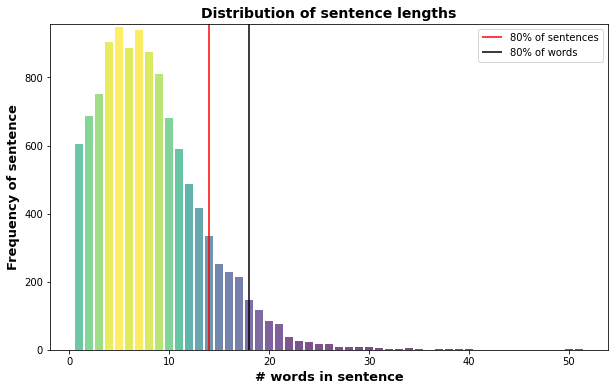

In [94]:
sentence_plot = df["Lemma"].values
sentence_plot_sorted = list(sorted(sentence_plot, key=len))
c = Counter(map(len, sentence_plot_sorted))

total_sentences = 0
total_words = 0
for i in c:
    total_sentences = total_sentences + c[i]
    total_words = total_words + c[i]*i

sentences_80_pct = total_sentences / 100 * 90
words_80_pct = total_words / 100 * 90

boundary_sen = 0
counter_sen = 0

for i in c:
    if(counter_sen + c[i] < int(sentences_80_pct)):
        counter_sen = counter_sen + c[i]
        boundary_sen = i
    else:
        break

boundary_word = 0
counter_word = 0

for i in c:
    if(counter_word + c[i] * i < int(words_80_pct)):
        counter_word = counter_word + c[i] * i
        boundary_word = i
    else:
        break


my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


plt.figure(figsize=[10,6])
bars = plt.bar(list(c.keys()), list(c.values()), color=my_cmap(rescale(list(c.values()))), width=0.8, alpha=0.7, align='center')

# for r in bars.get_children():
#     if(r.get_x() > boundary_sen):
#         r.set_alpha(0.2)

plt.legend(loc="best")
plt.ylim([0, max(list(c.values()))+10])
ax2 = plt.gca()

ymin, ymax = ax2.get_ylim()
plt.vlines(boundary_sen, ymin=ymin, ymax=ymax, colors='r', label='80% of sentences')
plt.vlines(boundary_word, ymin=ymin, ymax=ymax, colors='black', label="80% of words")

plt.ylabel('Frequency of sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.xlabel('# words in sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.title("Distribution of sentence lengths", fontdict={'fontsize':14, 'fontweight': 'bold'})
plt.legend()
plt.show()

In [95]:
tokens = df['Lemma_index'].tolist()
tags = df['Tag_index'].tolist()
pos = df['POS_index'].tolist()
dep = df['Dep_index'].tolist()
polarities = df['Polarity_rounded'].tolist()

max_length = boundary_sen
trunc_type = 'post'
pad_type = 'post'

pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)
pad_tags = pad_sequences(tags, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)
pad_pos = pad_sequences(pos, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)
pad_dep = pad_sequences(dep, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)

pad_polarities = pad_sequences(polarities, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type, value=10)
pad_polarities = [to_categorical(i, num_classes=len(pol_to_rep)) for i in pad_polarities]

train_tokens, test_tokens, train_polarities, test_polarities = train_test_split(pad_tokens, pad_polarities, test_size=0.25, random_state=42)
train_tags, test_tags, train_polarities, test_polarities = train_test_split(pad_tags, pad_polarities, test_size=0.25, random_state=42)
train_pos, test_pos, train_polarities, test_polarities = train_test_split(pad_pos, pad_polarities, test_size=0.25, random_state=42)
train_dep, test_dep, train_polarities, test_polarities = train_test_split(pad_dep, pad_polarities, test_size=0.25, random_state=42)

In [96]:
import os
import time
import tensorflow as tf
from keras import callbacks

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

model_name = 'words_multi_label_multi_feature'
model_variant = 'base'

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

my_callbacks = [earlystopping, lr_scheduler, tensorboard_cb]

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_input (InputLayer)        [(None, 14)]         0                                            
__________________________________________________________________________________________________
tag_input (InputLayer)          [(None, 14)]         0                                            
__________________________________________________________________________________________________
pos_input (InputLayer)          [(None, 14)]         0                                            
__________________________________________________________________________________________________
dep_input (InputLayer)          [(None, 14)]         0                                            
____________________________________________________________________________________________

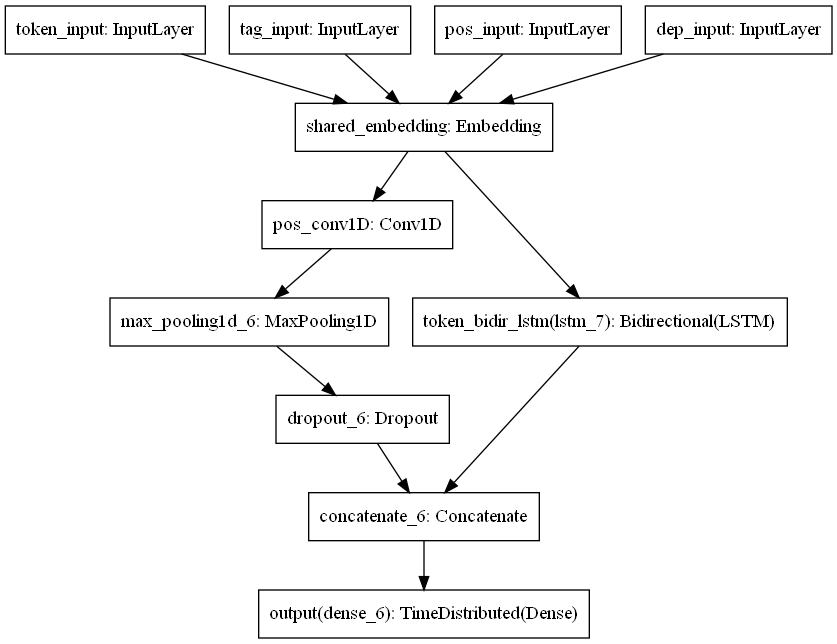

In [97]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import numpy as np
import tensorflow as tf

input_dim = len(lemma_vocab)+1
embedding_dim = 64
output_dim = 64

token_input = keras.Input(shape=(max_length,), name='token_input')
tag_input = keras.Input(shape=(max_length,), name='tag_input')
pos_input = keras.Input(shape=(max_length,), name='pos_input')
dep_input = keras.Input(shape=(max_length,), name='dep_input')

shared_embedding = layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length, mask_zero=True, name='shared_embedding')
shared_conv = layers.Conv1D(filters=64, kernel_size=len(pol_to_rep),  activation='relu', padding='same', name='pos_conv1D')
shared_pool = layers.MaxPooling1D(pool_size=1)
shared_drop = layers.Dropout(0.3)
token_bidir_lstm = layers.Bidirectional(layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat', name='token_bidir_lstm')


token_embedding = shared_embedding(token_input)
tag_embedding = shared_embedding(tag_input)
pos_embedding = shared_embedding(pos_input)
dep_embedding = shared_embedding(dep_input)

token_bidir_lstm = token_bidir_lstm(token_embedding)

tag_conv = shared_conv(tag_embedding)
pos_conv = shared_conv(pos_embedding)
dep_conv = shared_conv(dep_embedding)

tag_pool = shared_pool(tag_conv)
pos_pool = shared_pool(pos_conv)
dep_pool = shared_pool(dep_conv)

tag_do = shared_drop(tag_pool)
pos_do = shared_drop(pos_pool)
dep_do = shared_drop(dep_pool)

concat = layers.concatenate([token_bidir_lstm, tag_do, pos_do, dep_do])

output = layers.TimeDistributed(layers.Dense(len(pol_to_rep), activation="softmax"), name='output')(concat)

model = keras.Model(inputs=[token_input, tag_input, pos_input, dep_input], outputs=[output])

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 
model.summary()
plot_model(model)

In [98]:
history = model.fit([train_tokens, train_tags, train_pos, train_dep], np.array(train_polarities), epochs=50, callbacks=my_callbacks, validation_split=0.2)

model.save('classifiers/' + model_name + '/' + model_variant + '.h5')

Epoch 1/50
210/210 [==============================] - 11s 35ms/step - loss: 0.1335 - accuracy: 0.9303 - val_loss: 0.0037 - val_accuracy: 0.9988
Epoch 2/50
210/210 [==============================] - 6s 27ms/step - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 3/50
210/210 [==============================] - 6s 27ms/step - loss: 6.5255e-04 - accuracy: 0.9998 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 4/50
210/210 [==============================] - 6s 27ms/step - loss: 6.7566e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9996
Epoch 5/50
210/210 [==============================] - 5s 26ms/step - loss: 2.2033e-05 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 0.9996
Epoch 6/50
210/210 [==============================] - 6s 26ms/step - loss: 1.6136e-05 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 0.9996
Epoch 7/50
210/210 [==============================] - 6s 26ms/step - loss: 1.2945e-05 - accuracy: 1.0000 - val_loss: 0.0023 -

In [99]:
y_pred = model.predict([test_tokens, test_tags, test_pos, test_dep])

[10 10  5 10 10 10  9 10 10  8 10 14 10  9 11  9  9 10 10 10 10 10 10 10
 10 10 10 10  9 10] [10 10  5 10 10 10  9 10 10  8 10 14 10  9 11  9  9 10 10 10 10 10 10 10
 10 10 10 10  9 10]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


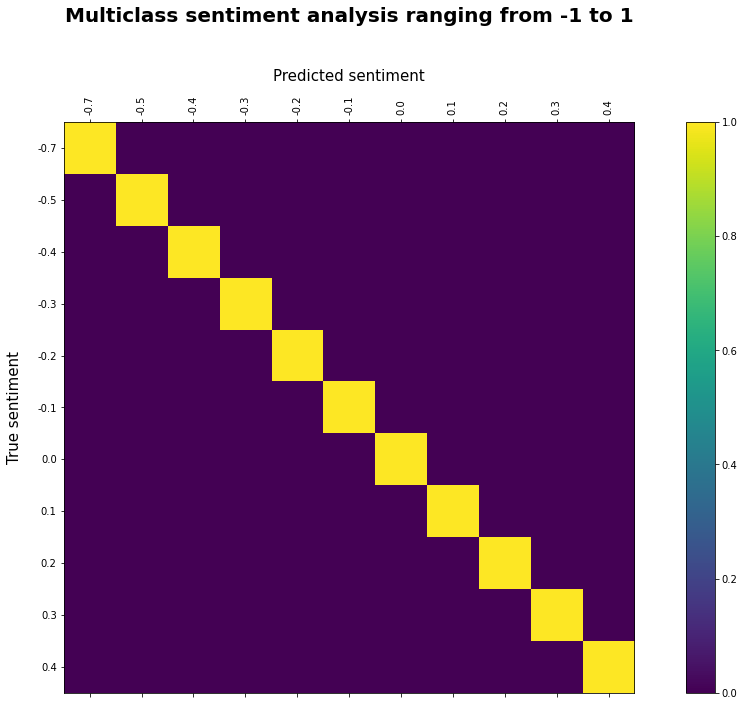

In [100]:
from sklearn.metrics import confusion_matrix
from itertools import chain

y_classes = y_pred.argmax(axis=-1)
cm_true = np.array(test_polarities).argmax(axis=-1).flatten()
cm_pred = y_classes.flatten()

#cm_true = [x - 10 for x in cm_true]
#cm_pred = [x - 10 for x in cm_pred]


print(cm_true[:30], cm_pred[:30])


cm = confusion_matrix(cm_true, cm_pred, normalize='pred')

print(cm[0])

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted sentiment', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True sentiment', fontsize = 15, labelpad=15.0)
ax.set_title('Multiclass sentiment analysis ranging from -1 to 1',fontweight="bold", size=20, pad=100.0)

conf_x = []

temp = set(chain(*df['Polarity_rounded']))

for i in temp:
    conf_x.append(i)

print(sorted(conf_x))

cm_axis_vals = []

for x in np.unique(np.array(cm_pred)):
    cm_axis_vals.append(rep_to_pol[x])


fig.colorbar(cax)
plt.xticks(range(len(cm[0])),cm_axis_vals, rotation=90)
plt.yticks(range(len(cm[0])), cm_axis_vals)
plt.show()

In [55]:
report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:11]
df_perf_2.insert(loc=0, column='Polarity', value=conf_x)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\hanse\AppData\Local\Temp/ipykernel_10288/826983249.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Polarity,precision,recall,f1-score,support
0,3,1.0,1.0,1.0,47.0
1,5,1.0,1.0,1.0,430.0
2,6,1.0,1.0,1.0,397.0
3,7,1.0,1.0,1.0,640.0
4,8,1.0,1.0,1.0,1655.0
5,9,1.0,1.0,1.0,6128.0
6,10,1.0,1.0,1.0,28369.0
7,11,1.0,1.0,1.0,912.0
8,12,1.0,1.0,1.0,288.0
9,13,1.0,1.0,1.0,114.0


In [101]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [102]:
import json

data = {
    "articles": [
        {
        "gender": "M",
        "text": "A man was walking down the street angrily. He was very aggresive towards all other people. He yelled at the top of his lungs."
        },
        {
        "gender": "W",
        "text": "A woman sat a hair salon. She was very pretty. Her legs was full of hair though, like an ape."
        },
    ]
}

with open('../datasets/6_word_polarity.json') as json_file:
    polarity_dict = json.load(json_file)

corpus =    {
                'Sentence #': [], 
                'Word': [],
                'Lemma': [],
                'Tag': [],
                'POS': [],
                'Dep': [],
                'Polarity': [],
                'Gender': []
            }

sentenceCount = 1

ignore_terms = ['.', ',', '...', ' ', '\u2019', '  ', '(', ')', '?', '\u00a3', '/', '"', ':', ';', '-', '--', '\u2015', "'", '!', '$', '#', '\u2014', '   ', '[',']']
ignore_ents = ['TIME', 'DATE', 'GPE', 'CARDINAL', 'PERSON', 'MONEY', 'PERCENT']

for article in data['articles']:
    doc = nlp(article['text'])
    assert doc.has_annotation("SENT_START")
    for sent in doc.sents:
        for token in sent:
            if not token.is_stop and token.lemma_ not in ignore_terms and token.ent_type_ not in ignore_ents:
                corpus['Sentence #'].append(sentenceCount)
                corpus['Word'].append(token.text)
                corpus['Lemma'].append(token.lemma_)
                corpus['Tag'].append(token.tag_)
                corpus['POS'].append(token.pos_)
                corpus['Dep'].append(token.dep_)
                corpus['Polarity'].append(polarity_dict[token.lemma_] if token.lemma_ in polarity_dict else 0)
                corpus['Gender'].append(article['gender'])
        sentenceCount += 1

with open('../datasets/9_simple_tests.json', "w") as out_file:
            json.dump(corpus, out_file)

In [108]:
df = pd.read_json('../datasets/9_simple_tests.json')
df

,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,Gender
0,1,man,man,NN,NOUN,nsubj,0.069009,M
1,1,walking,walk,VBG,VERB,ROOT,-0.023034,M
2,1,street,street,NN,NOUN,pobj,0.007714,M
3,1,angrily,angrily,RB,ADV,advmod,-0.003441,M
4,2,aggresive,aggresive,JJ,ADJ,acomp,0.000000,M
5,2,people,people,NNS,NOUN,pobj,-0.418319,M
6,3,yelled,yell,VBD,VERB,ROOT,-0.009672,M
7,3,lungs,lung,NNS,NOUN,pobj,-0.006973,M
8,4,woman,woman,NN,NOUN,nsubj,0.256108,W
9,4,sat,sit,VBD,VERB,ROOT,-0.049303,W


In [109]:

df['Sentiment'] = df.Gender.apply(lambda x: -1 if x == "M" else 1)
df = df.drop('Gender', axis=1)
df['Dep'] = df['Dep'].str.upper()
df['Polarity_rounded'] = df['Polarity'].apply(lambda s: pol_to_rep[round(float(s), 1)])

df['Lemma_index'] = df['Lemma'].map(lemma_to_i)
df['Tag_index'] = df['Tag'].map(tag_to_i)
df['POS_index'] = df['POS'].map(pos_to_i)
df['Dep_index'] = df['Dep'].map(dep_to_i)

df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'Sentiment', 'Polarity_rounded', 'Lemma_index', 'Tag_index', 'POS_index', 'Dep_index'].agg(lambda x: list(x))
df

C:\Users\hanse\AppData\Local\Temp/ipykernel_10288/1762937506.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'Sentiment', 'Polarity_rounded', 'Lemma_index', 'Tag_index', 'POS_index', 'Dep_index'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,Sentiment,Polarity_rounded,Lemma_index,Tag_index,POS_index,Dep_index
0,1,"[man, walking, street, angrily]","[man, walk, street, angrily]","[NN, VBG, NN, RB]","[NOUN, VERB, NOUN, ADV]","[NSUBJ, ROOT, POBJ, ADVMOD]","[0.06900853170740501, -0.023033807687096, 0.00...","[-1, -1, -1, -1]","[11, 10, 10, 10]","[7408.0, 11235.0, 10190.0, nan]","[18, 33, 18, 24]","[8, 17, 8, 3]","[27, 41, 33, 4]"
1,2,"[aggresive, people]","[aggresive, people]","[JJ, NNS]","[ADJ, NOUN]","[ACOMP, POBJ]","[0.0, -0.418318935861613]","[-1, -1]","[10, 6]","[nan, 8348.0]","[12, 21]","[1, 8]","[2, 33]"
2,3,"[yelled, lungs]","[yell, lung]","[VBD, NNS]","[VERB, NOUN]","[ROOT, POBJ]","[-0.00967162427526, -0.006972853671765001]","[-1, -1]","[10, 10]","[nan, nan]","[32, 21]","[17, 8]","[41, 33]"
3,4,"[woman, sat, hair, salon]","[woman, sit, hair, salon]","[NN, VBD, NN, NN]","[NOUN, VERB, NOUN, NOUN]","[NSUBJ, ROOT, COMPOUND, DOBJ]","[0.256108371099879, -0.04930252083797, 0.29453...","[1, 1, 1, 1]","[13, 10, 13, 10]","[11379.0, 9794.0, 6263.0, 9451.0]","[18, 32, 18, 18]","[8, 17, 8, 8]","[27, 41, 13, 20]"
4,5,[pretty],[pretty],[JJ],[ADJ],[ACOMP],[0.00035658512672400003],[1],[10],[8683.0],[12],[1],[2]
5,6,"[legs, hair, like, ape]","[leg, hair, like, ape]","[NNS, NN, IN, NN]","[NOUN, NOUN, ADP, NOUN]","[NSUBJ, POBJ, PREP, POBJ]","[0.0029307453678120003, 0.294534142292879, -0....","[1, 1, 1, 1]","[10, 13, 9, 10]","[7168.0, 6263.0, 7243.0, nan]","[21, 18, 11, 18]","[8, 8, 2, 8]","[27, 33, 36, 33]"


In [113]:
tokens = df['Lemma_index'].tolist()
tags = df['Tag_index'].tolist()
pos = df['POS_index'].tolist()
dep = df['Dep_index'].tolist()
polarities = df['Polarity_rounded'].tolist()

In [119]:
df

,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,Sentiment,Polarity_rounded,Lemma_index,Tag_index,POS_index,Dep_index
0,1,"[man, walking, street, angrily]","[man, walk, street, angrily]","[NN, VBG, NN, RB]","[NOUN, VERB, NOUN, ADV]","[NSUBJ, ROOT, POBJ, ADVMOD]","[0.06900853170740501, -0.023033807687096, 0.00...","[-1, -1, -1, -1]","[11, 10, 10, 10]","[7408.0, 11235.0, 10190.0, nan]","[18, 33, 18, 24]","[8, 17, 8, 3]","[27, 41, 33, 4]"
1,2,"[aggresive, people]","[aggresive, people]","[JJ, NNS]","[ADJ, NOUN]","[ACOMP, POBJ]","[0.0, -0.418318935861613]","[-1, -1]","[10, 6]","[nan, 8348.0]","[12, 21]","[1, 8]","[2, 33]"
2,3,"[yelled, lungs]","[yell, lung]","[VBD, NNS]","[VERB, NOUN]","[ROOT, POBJ]","[-0.00967162427526, -0.006972853671765001]","[-1, -1]","[10, 10]","[nan, nan]","[32, 21]","[17, 8]","[41, 33]"
3,4,"[woman, sat, hair, salon]","[woman, sit, hair, salon]","[NN, VBD, NN, NN]","[NOUN, VERB, NOUN, NOUN]","[NSUBJ, ROOT, COMPOUND, DOBJ]","[0.256108371099879, -0.04930252083797, 0.29453...","[1, 1, 1, 1]","[13, 10, 13, 10]","[11379.0, 9794.0, 6263.0, 9451.0]","[18, 32, 18, 18]","[8, 17, 8, 8]","[27, 41, 13, 20]"
4,5,[pretty],[pretty],[JJ],[ADJ],[ACOMP],[0.00035658512672400003],[1],[10],[8683.0],[12],[1],[2]
5,6,"[legs, hair, like, ape]","[leg, hair, like, ape]","[NNS, NN, IN, NN]","[NOUN, NOUN, ADP, NOUN]","[NSUBJ, POBJ, PREP, POBJ]","[0.0029307453678120003, 0.294534142292879, -0....","[1, 1, 1, 1]","[10, 13, 9, 10]","[7168.0, 6263.0, 7243.0, nan]","[21, 18, 11, 18]","[8, 8, 2, 8]","[27, 33, 36, 33]"


In [118]:
tokens

[[7408.0, 11235.0, 10190.0, nan],
 [nan, 8348.0],
 [nan, nan],
 [11379.0, 9794.0, 6263.0, 9451.0],
 [8683.0],
 [7168.0, 6263.0, 7243.0, nan]]

In [117]:
pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)

ValueError: cannot convert float NaN to integer

In [115]:
pad_tokens = pad_sequences(tokens, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)
pad_tags = pad_sequences(tags, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)
pad_pos = pad_sequences(pos, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)
pad_dep = pad_sequences(dep, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type)

pad_polarities = pad_sequences(polarities, maxlen=max_length, dtype='int32', padding=pad_type, truncating=trunc_type, value=10)
pad_polarities = [to_categorical(i, num_classes=len(pol_to_rep)) for i in pad_polarities]


SyntaxError: invalid syntax (Temp/ipykernel_10288/2199447200.py, line 1)

In [105]:
y_pred = model.predict([test_tokens, test_tags, test_pos, test_dep])
y_classes = y_pred.argmax(axis=-1)
len(y_classes)

2801

In [106]:


cm_axis_vals = []

for x in np.array(y_classes):
    print(x)
    # cm_axis_vals.append(rep_to_pol[x])

cm_axis_vals

[10 10  5 10 10 10  9 10 10  8 10 14 10  9]
[11  9  9 10 10 10 10 10 10 10 10 10 10 10]
[ 9 10  9 11 10  9  9  6  9  9  9 10 10 10]
[ 5 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10  9  9  8 10 10 10 10 10 10 10 10 10 10]
[10 10 10  9 10 10  6 10 10  7  7 10 10  9]
[10 10 10  9  9 10 10 10 10 10 10 10 10 10]
[10 10 10  5  9 10  9  5  8 10 10 10 10 10]
[ 9 10 10 10 10 10  9 10 10 11 10  9 11 10]
[11 10  8 10 10 10 10 10 10 10 10 10 10 10]
[10  9 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10  5  7 10  9 10 10 10 10 10 10 10]
[ 5  8 10  9  9 12  9 12  8 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10 10 10 10 11 10 10 10 10 10 10 10 10]
[ 9  6 10 10  9 10  9 10 10 10 10 10 10 10]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10]
[10 10  9  9 10 10 10 10 10 10 10 10 10 10]
[10  9  9  8 10  9 10 10 10 10 10 10 10 10]
[ 9  5 10  9 10 10 10 10 10 10 10 10 10 10]
[14  9  7 11 10 10 11 10 10  9  9  9 10 11]
[ 8 10  8 10 10  6 10 10 10 10 1

[]